#### Libraries


In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
import csv
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import os
import itertools
from print_color import print

# 3D to 2D


#### MIP


In [2]:
def mip(image: np.ndarray)->np.ndarray:
    """Create the maximum intensity projection.
    """
    maximum_intensity_projection = np.max(image, axis=0)
    maximum_intensity_projection = np.clip(maximum_intensity_projection, -100, 300)
    
    return maximum_intensity_projection

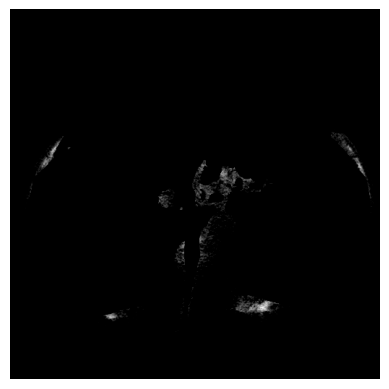

In [42]:
image = sitk.ReadImage('c:/users/sven/Documents/BEP/simplified_data\B04\IMAGES\B04.nii.gz')
img_data = sitk.GetArrayFromImage(image)

mask = sitk.ReadImage('c:/users/sven/Documents/BEP/simplified_data\B04\MASKS\B04.nii.gz')
mask_data = sitk.GetArrayFromImage(mask)

plt.imshow(minip(img_data), cmap='gray')
plt.axis('off')
plt.show()

#### AIP


In [4]:
def aip(image: np.ndarray)->np.ndarray:
    """Create a mean image projection.
    """
    average_intensity_projection = np.mean(image,axis=0)
    average_intensity_projection = np.clip(average_intensity_projection,-100,300)
    
    return average_intensity_projection

#### SLICE


In [5]:
def find_tumor_center(mask: np.ndarray)->int:
    """Find the center of the tumor. 
    """
    return np.clip(np.argmax(np.sum(mask, axis=(1, 2))),-100,300)

In [6]:
def slice_tc(image: np.ndarray, mask: np.ndarray)->np.ndarray:
    """Take a slice at the center of the tumor.
    """
    x1 = find_tumor_center(mask)
    return np.clip(image[x1, :, :],-100,300)

#### TUMOR MIP

In [7]:
def tumor_mip(image: np.ndarray, mask: np.ndarray)->np.ndarray:
    """Return the mip of the tumor only.
    """
    return np.clip(np.max(image * mask, axis=0),-100,300)

#### MINIP

In [8]:
def minip(image: np.ndarray)->np.ndarray:
    """Create the maximum intensity projection.
    """
    return np.clip(np.min(image, axis=0),-100,300)

# Convert the images


In [9]:
MIP = []
AIP = []
SLICE = []
TUMOR_MIP = []
MINIP = []

with open('c:/users/sven/Documents/BEP_sbierenbroodspot_1334859/Pyradiomics/v5/folderNames2.csv', newline='') as file:
    reader = csv.reader(file)
    next(reader)
    
    for row in reader:
        img_data = sitk.GetArrayFromImage(sitk.ReadImage(row[1]))

        if os.path.exists(row[2]):
            mask_data = sitk.GetArrayFromImage(sitk.ReadImage(row[2]))
        else:
            mask_l = sitk.GetArrayFromImage(sitk.ReadImage(row[3]))
            mask_r = sitk.GetArrayFromImage(sitk.ReadImage(row[4]))
            mask_data = mask_l+mask_r

        MIP.append(mip(img_data))
        AIP.append(aip(img_data))
        SLICE.append(slice_tc(img_data,mask_data))
        TUMOR_MIP.append(tumor_mip(img_data,mask_data))
        MINIP.append(minip(img_data))

# feature extraction


In [10]:
def IAC(layout: list, i: int) -> np.ndarray:
    """
    Create the 512x512x3 input array for feature extraction.
    """
    slots = [MIP[i], AIP[i], SLICE[i], TUMOR_MIP[i], MINIP[i]]
    input_array = np.dstack([slots[layout[j] - 1] for j in range(3)])
    return input_array

#### Model


In [11]:
timm.list_models(pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [20]:
model = timm.create_model('efficientnetv2_rw_m', pretrained=True)
model.eval()
model.to('cuda')


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): Identity()
        (conv_pwl): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (1): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_s

#### Feature extraction single image

In [13]:
def feature_extraction(input_array: np.ndarray)-> np.ndarray:
    """Extract the features of a single image.
    """ 
    
    # Convert numpy array to torch tensor and normalize
    input_tensor = torch.from_numpy(np.transpose(input_array, (2, 0, 1))).float()
    input_tensor = input_tensor.to('cuda')
    input_tensor = (input_tensor + 100) / (300 + 100)
    input_tensor = input_tensor.unsqueeze(0)

    # Extract features using ResNet50
    with torch.no_grad():
        features = model.forward_features(input_tensor)
        features = torch.mean(features, dim=[2, 3])

    # Convert features to numpy array
    features = features.to('cpu')
    features_array = features.numpy()
    
    return features_array

#### Feature extraction full dataset

In [21]:
def feature_extraction_full(layout: list) -> np.ndarray:
    """Extract all features of the dataset for an input layout.
    """
    result = np.empty((0, 2152))

    for i in range(len(MIP)):
        result_vector = feature_extraction(IAC(layout, i))
        result = np.vstack([result, result_vector])    
    return result

#### Extract manual result


In [22]:
result  = feature_extraction_full([4, 4, 2])
print(svm_auc_max(result, labels))
np.savetxt("result.csv", result, delimiter=",")

0.8200000000000001


# Labels


In [15]:
labels = np.empty((0,0))
with open('c:/users/sven/Documents/BEP_sbierenbroodspot_1334859/Technical_research/Labels.csv', newline='') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        labels = np.append(labels, row[0])

# SVM


In [16]:
def svm_auc(data: np.ndarray, labels: np.ndarray)->np.float64:
    """Get the AUC for a svm.
    """

    # Create a stratified 5-fold cross-validation object
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize an SVM classifier
    svm = SVC(kernel='linear', probability=True)

    # Store the AUC scores
    auc_scores = []

    # Perform cross-validation
    for train_idx, test_idx in cv.split(data, labels):
        # Split the data and labels
        X_train, X_test = data[train_idx], data[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        # Train the SVM classifier
        svm.fit(X_train, y_train)

        # Predict the probabilities for the test set
        y_pred_proba = svm.predict_proba(X_test)[:, 1]

        # Compute the AUC score
        auc_score = roc_auc_score(y_test, y_pred_proba)

        # Store the AUC score
        auc_scores.append(auc_score)

    return np.mean(auc_scores)

In [17]:
def svm_auc_max(data: np.ndarray, labels: np.ndarray)->np.float64:
    """Get the max AUC out of a constant amount of tries.
    """
    # Initialize a variable to store the maximum output
    max_output = -np.inf

    # Iterate over the function 20 times
    for i in range(100):
        # Compute the output of the function
        output = svm_auc(data, labels)

        # Update the maximum output if necessary
        if output > max_output:
            max_output = output
    return max_output

# Get all results

In [35]:
auc = []

for i in range(1, 5):
    for j in range(1, 5):
        for k in range(1, 5):
            my_list = [i, j, k]
            auc_ = svm_auc_max(feature_extraction_full(my_list),labels)
            auc.append(auc_)
            #if auc_ > 0.7:
            print(my_list, auc_)



[1, 1, 1] 0.6028282828282828
[1, 1, 2] 0.5860606060606062
[1, 1, 3] 0.5375757575757576
[1, 1, 4] 0.5487878787878788
[1, 2, 1] 0.5604040404040405
[1, 2, 2] 0.477979797979798


KeyboardInterrupt: 

In [76]:
np.savetxt("aucs.csv", auc, delimiter=",")

# Results for 5 configs

In [22]:
auc = []

for i in range(1, 6):
    for j in range(1, 6):
        for k in range(1, 6):
            
            my_list = [i, j, k]
            auc_ = svm_auc_max(feature_extraction_full(my_list),labels)
            auc.append(auc_)
            if auc_ > 0.55 and auc_ < 0.7:
                print(my_list, auc_, tag='medium', tag_color='yellow', color = 'black')
            elif auc_ >= 0.7:
                print(my_list, auc_, tag='good', tag_color='green', color = 'black')
            else:
                print(my_list, auc_, tag='bad', tag_color='red', color = 'black')
            

[bad] [1, 1, 1] 0.5464646464646463
[medium] [1, 1, 2] 0.5624242424242424
[medium] [1, 1, 3] 0.588989898989899
[medium] [1, 1, 4] 0.6015151515151514
[medium] [1, 1, 5] 0.5806060606060606
[medium] [1, 2, 1] 0.5717171717171716
[medium] [1, 2, 2] 0.5934343434343434
[bad] [1, 2, 3] 0.5365656565656566
[medium] [1, 2, 4] 0.6363636363636365
[medium] [1, 2, 5] 0.6070707070707071
[medium] [1, 3, 1] 0.5751515151515152
[bad] [1, 3, 2] 0.535959595959596
[bad] [1, 3, 3] 0.5228282828282829
[medium] [1, 3, 4] 0.5636363636363637
[medium] [1, 3, 5] 0.5874747474747475
[medium] [1, 4, 1] 0.598888888888889
[medium] [1, 4, 2] 0.6231313131313132
[bad] [1, 4, 3] 0.5456565656565656
[bad] [1, 4, 4] 0.525050505050505
[medium] [1, 4, 5] 0.5966666666666667
[medium] [1, 5, 1] 0.5872727272727273
[medium] [1, 5, 2] 0.6191919191919192
[bad] [1, 5, 3] 0.5369696969696971
[medium] [1, 5, 4] 0.6295959595959596
[medium] [1, 5, 5] 0.592121212121212
[medium] [2, 1, 1] 0.5614141414141415
[bad] [2, 1, 2] 0.5381818181818182
[me

In [23]:
np.savetxt("aucs.csv", auc, delimiter=",")

# String generation

In [41]:
with open('my_file.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for i in range(1, 6):
        for j in range(1, 6):
            for k in range(1, 6):
               
                my_list = [i, j, k]
                    
                csvwriter.writerow([str(my_list)])